In [1]:
# Comprehensive Cluster Analysis for Different Metal-Chloride Types
# This notebook implements separate clustering for different metal-chloride combinations

from ovito.io import import_file
from ovito.modifiers import CreateBondsModifier, SelectTypeModifier
from ovito.data import BondsEnumerator
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# --- user inputs ---
infile = "/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.40/T1100K/dump.lammpstrj"

# We'll calculate these from RDF data instead of hardcoding
r_PuCl = None   # Will be determined from RDF first minimum
r_NaCl = None   # Will be determined from RDF first minimum
r_NaNa = None   # Will be determined from RDF first minimum
r_PuPu = None   # Will be determined from RDF first minimum
r_ClCl = None   # Will be determined from RDF first minimum
r_NaPu = None   # Will be determined from RDF first minimum


In [3]:
# First, let's set up RDF calculation to determine proper cutoffs
from ovito.modifiers import CoordinationAnalysisModifier
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load the trajectory
pipe = import_file(infile, multiple_frames=True)

# Add RDF calculation modifier with partial RDFs enabled
rdf_modifier = CoordinationAnalysisModifier(
    cutoff=8.0,  # Maximum distance for RDF calculation
    number_of_bins=200,
    partial=True  # Enable partial RDFs for different atom pairs
)
pipe.modifiers.append(rdf_modifier)

# (Optional) ensure types exist and have names 'Pu','Na','Cl' in your dump.

In [7]:
# Function to calculate RDFs and find first minimum distances
def calculate_rdfs_and_cutoffs(pipeline, nsamples=500):
    """Calculate RDFs and find first minimum distances for bond cutoffs"""
    nframes = pipeline.source.num_frames
    rdf_data = {}
    
    print(f"Calculating RDFs from last {nsamples} frames...")
    
    for frame in tqdm(range(nframes - nsamples, nframes)):
        data = pipeline.compute(frame)
        # Access the output DataTable:
        rdf_table = data.tables['coordination-rdf']
        
        # The y-property of the data points of the DataTable is now a vectorial property.
        # Each vector component represents one partial RDF.
        rdf_names = rdf_table.y.component_names
        
        # Process each partial RDF
        for component, name in enumerate(rdf_names):
            elements = sorted(name.split('-'))
            unique_name = '-'.join(elements)
            
            y = rdf_table.y[:,component]
            if rdf_data.get(unique_name, None) is None:
                rdf_data[unique_name] = [y]
            else:
                rdf_data[unique_name].append(y)
    
    # Average over all frames
    for name in rdf_data:
        rdf_data[name] = np.vstack(rdf_data[name]).mean(axis=0)
    
    rdf_data["r"] = rdf_table.xy()[:, 0]
    
    return rdf_data

# Function to find first minimum in RDF
def find_first_minimum(r, g_r, min_distance=1.0, max_distance=8.0):
    """Find the first minimum in g(r) between min_distance and max_distance"""
    # Filter the range
    mask = (r >= min_distance) & (r <= max_distance)
    r_filtered = r[mask]
    g_filtered = g_r[mask]
    
    if len(g_filtered) < 3:
        return None
    
    # Find local minima
    from scipy.signal import find_peaks
    # Invert g(r) to find minima as peaks
    peaks, _ = find_peaks(-g_filtered, prominence=0.5)   # g(r) should be > 0.5 for a minimum
    
    if len(peaks) > 0:
        # Return the first minimum
        return r_filtered[peaks[0]]
    else:
        # Fallback: find where g(r) first drops below 1.0 after the first peak
        first_peak_idx = np.argmax(g_filtered)
        for i in range(first_peak_idx, len(g_filtered)):
            if g_filtered[i] < 1.0:
                return r_filtered[i]
        return None


In [8]:
# Calculate RDFs and determine cutoffs
print("Calculating RDFs to determine bond cutoffs...")
rdf_data = calculate_rdfs_and_cutoffs(pipe, nsamples=100)  # Use fewer samples for speed

# Find cutoffs for metal-chlorine pairs
r = rdf_data["r"]

# Check what RDFs we actually have
print(f"Available RDFs: {list(rdf_data.keys())}")

# Cl-Pu cutoff (alphabetical order)
if "Cl-Pu" in rdf_data:
    r_PuCl = find_first_minimum(r, rdf_data["Cl-Pu"], min_distance=2.0, max_distance=8.0)
    print(f"Cl-Pu first minimum: {r_PuCl:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_PuCl = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Cl-Pu cutoff: {r_PuCl:.3f} Å")
else:
    r_PuCl = 3.10  # fallback
    print("Cl-Pu RDF not found, using fallback cutoff")

# Cl-Na cutoff (alphabetical order)
if "Cl-Na" in rdf_data:
    r_NaCl = find_first_minimum(r, rdf_data["Cl-Na"], min_distance=2.0, max_distance=8.0)
    print(f"Cl-Na first minimum: {r_NaCl:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_NaCl = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Cl-Na cutoff: {r_NaCl:.3f} Å")
else:
    r_NaCl = 3.10  # fallback
    print("Cl-Na RDF not found, using fallback cutoff")

# Na-Na cutoff (alphabetical order)
if "Na-Na" in rdf_data:
    r_NaNa = find_first_minimum(r, rdf_data["Na-Na"], min_distance=2.0, max_distance=8.0)
    print(f"Na-Na first minimum: {r_NaNa:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_NaNa = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Na-Na cutoff: {r_NaNa:.3f} Å")
else:
    r_NaNa = 3.10  # fallback
    print("Na-Na RDF not found, using fallback cutoff")

# Pu-Pu cutoff (alphabetical order)
if "Pu-Pu" in rdf_data:
    r_PuPu = find_first_minimum(r, rdf_data["Pu-Pu"], min_distance=2.0, max_distance=8.0)
    print(f"Pu-Pu first minimum: {r_PuPu:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_PuPu = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Pu-Pu cutoff: {r_PuPu:.3f} Å")
else:
    r_PuPu = 3.10  # fallback
    print("Pu-Pu RDF not found, using fallback cutoff")

# Pu-Na cutoff (alphabetical order)
if "Na-Pu" in rdf_data:
    r_NaPu = find_first_minimum(r, rdf_data["Na-Pu"], min_distance=2.0, max_distance=8.0)
    print(f"Na-Pu first minimum: {r_NaPu:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_NaPu = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Na-Pu cutoff: {r_NaPu:.3f} Å")

# Cl-Cl cutoff (alphabetical order)
if "Cl-Cl" in rdf_data:
    r_ClCl = find_first_minimum(r, rdf_data["Cl-Cl"], min_distance=2.0, max_distance=8.0)
    print(f"Cl-Cl first minimum: {r_ClCl:.3f} Å")
elif "total" in rdf_data:
    # Use total RDF as fallback
    r_ClCl = find_first_minimum(r, rdf_data["total"], min_distance=2.0, max_distance=8.0)
    print(f"Using total RDF for Cl-Cl cutoff: {r_ClCl:.3f} Å")
else:
    r_ClCl = 3.10  # fallback
    print("Cl-Cl RDF not found, using fallback cutoff")




Calculating RDFs to determine bond cutoffs...
Calculating RDFs from last 100 frames...


100%|██████████| 100/100 [00:01<00:00, 75.50it/s]

Available RDFs: ['Na-Na', 'Cl-Na', 'Na-Pu', 'Cl-Cl', 'Cl-Pu', 'Pu-Pu', 'r']
Cl-Pu first minimum: 3.860 Å
Cl-Na first minimum: 4.220 Å
Na-Na first minimum: 5.500 Å
Pu-Pu first minimum: 6.300 Å
Na-Pu first minimum: 5.740 Å
Cl-Cl first minimum: 4.500 Å


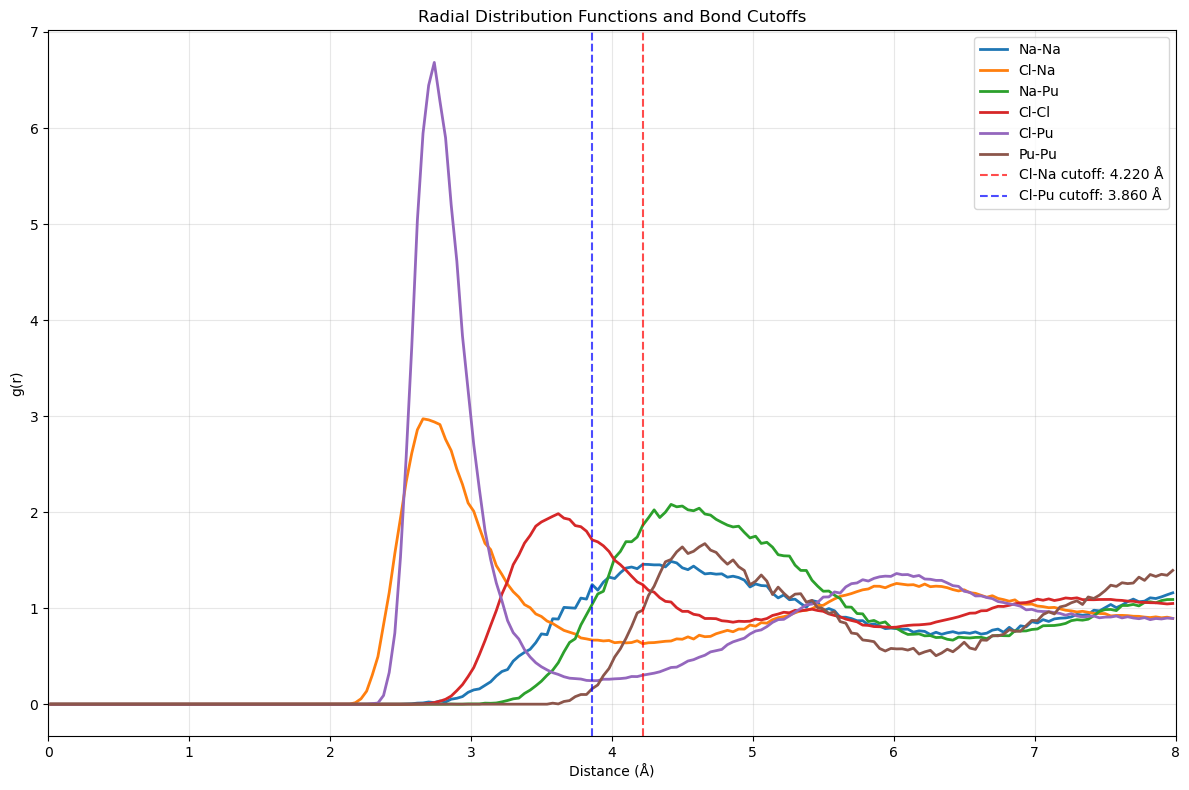


RDF Data Summary:
Number of distance points: 200
Distance range: 0.020 - 7.980 Å
Na-Na: max g(r) = 1.487 at r = 4.420 Å
Cl-Na: max g(r) = 2.972 at r = 2.660 Å
Na-Pu: max g(r) = 2.080 at r = 4.420 Å
Cl-Cl: max g(r) = 1.984 at r = 3.620 Å
Cl-Pu: max g(r) = 6.683 at r = 2.740 Å
Pu-Pu: max g(r) = 1.672 at r = 4.660 Å


In [11]:
# Plot the RDFs to visualize the cutoffs
plt.figure(figsize=(12, 8))

# Plot all available RDFs
for name, g_r in rdf_data.items():
    if name != "r":
        plt.plot(r, g_r, label=name, linewidth=2)

# Mark the determined cutoffs

if r_NaCl:
    plt.axvline(r_NaCl, color='red', linestyle='--', alpha=0.7, label=f'Cl-Na cutoff: {r_NaCl:.3f} Å')

if r_PuCl:
    plt.axvline(r_PuCl, color='blue', linestyle='--', alpha=0.7, label=f'Cl-Pu cutoff: {r_PuCl:.3f} Å')

plt.xlabel('Distance (Å)')
plt.ylabel('g(r)')
plt.title('Radial Distribution Functions and Bond Cutoffs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 8)
# plt.ylim(0, 5)
plt.tight_layout()
plt.show()

# Print some diagnostic information
print(f"\nRDF Data Summary:")
print(f"Number of distance points: {len(r)}")
print(f"Distance range: {r[0]:.3f} - {r[-1]:.3f} Å")
for name, g_r in rdf_data.items():
    if name != "r":
        print(f"{name}: max g(r) = {np.max(g_r):.3f} at r = {r[np.argmax(g_r)]:.3f} Å")


In [12]:
# Now create a new pipeline for cluster analysis with RDF-determined cutoffs
# Remove the RDF modifier and add bond creation with calculated cutoffs
pipe_cluster = import_file(infile, multiple_frames=True)

# Create bonds using RDF-determined cutoffs
cb = CreateBondsModifier(mode=CreateBondsModifier.Mode.Pairwise)
cb.set_pairwise_cutoff('Pu', 'Cl', r_PuCl)
cb.set_pairwise_cutoff('Cl', 'Pu', r_PuCl)  # symmetric
cb.set_pairwise_cutoff('Na', 'Cl', r_NaCl)
cb.set_pairwise_cutoff('Cl', 'Na', r_NaCl)

cb.set_pairwise_cutoff('Na', 'Na', r_NaNa)
cb.set_pairwise_cutoff('Pu', 'Pu', r_PuPu)

cb.set_pairwise_cutoff('Pu', 'Na', r_NaPu)
cb.set_pairwise_cutoff('Na', 'Pu', r_NaPu)

cb.set_pairwise_cutoff('Cl', 'Cl', r_ClCl)

pipe_cluster.modifiers.append(cb)

# (Optional) keep only metals for reporting later
pipe_cluster.modifiers.append(SelectTypeModifier(types={'Pu','Na'}))

print("Pipeline set up with RDF-determined cutoffs for cluster analysis")


Pipeline set up with RDF-determined cutoffs for cluster analysis


In [13]:
# Function to analyze specific cluster types
def analyze_cluster_type(data, cluster_type, frame=0):
    """
    Analyze specific types of clusters:
    - 'Na-Cl': Only Na-Cl bonds
    - 'Pu-Cl': Only Pu-Cl bonds  
    - 'Na-Na': Only Na-Na bonds
    - 'Pu-Pu': Only Pu-Pu bonds
    - 'Na-Cl-mixed': Na-Cl bonds + Na-Na bonds
    - 'Pu-Cl-mixed': Pu-Cl bonds + Pu-Pu bonds
    """
    
    # Get particle data
    parts = data.particles
    particle_types = parts['Particle Type']
    types = parts.particle_types
    names = np.array([types.type_by_id(t).name for t in particle_types])
    positions = parts['Position']
    
    # Get bonds
    bonds = parts.bonds
    if not bonds or len(bonds) == 0:
        print(f"No bonds found for {cluster_type} analysis!")
        return None, None, None
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add all particles as nodes
    G.add_nodes_from(range(len(names)))
    
    # Add edges based on cluster type
    bonds_added = 0
    for bond_idx, (atom1, atom2) in enumerate(bonds.topology):
        type1, type2 = names[atom1], names[atom2]
        
        # Determine if this bond should be included based on cluster type
        include_bond = False
        
        if cluster_type == 'Na-Cl':
            include_bond = (type1 == 'Na' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Na')
        elif cluster_type == 'Pu-Cl':
            include_bond = (type1 == 'Pu' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Pu')
        elif cluster_type == 'Na-Na':
            include_bond = (type1 == 'Na' and type2 == 'Na')
        elif cluster_type == 'Pu-Pu':
            include_bond = (type1 == 'Pu' and type2 == 'Pu')
        elif cluster_type == 'Na-Cl-mixed':
            include_bond = ((type1 == 'Na' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Na') or 
                           (type1 == 'Na' and type2 == 'Na'))
        elif cluster_type == 'Pu-Cl-mixed':
            include_bond = ((type1 == 'Pu' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Pu') or 
                           (type1 == 'Pu' and type2 == 'Pu'))
        
        if include_bond:
            G.add_edge(atom1, atom2)
            bonds_added += 1
    
    print(f"Added {bonds_added} bonds for {cluster_type} analysis")
    
    # Find connected components (clusters)
    components = list(nx.connected_components(G))
    
    # Create cluster ID array
    cluster_ids = np.full(len(names), -1, dtype=int)
    cluster_sizes = []
    
    for cid, component in enumerate(components):
        cluster_sizes.append(len(component))
        for atom_idx in component:
            cluster_ids[atom_idx] = cid
    
    return cluster_ids, cluster_sizes, G


In [14]:
# Function to visualize clusters for a specific type
def visualize_cluster_type(data, cluster_ids, names, cluster_type, max_clusters=10):
    """Visualize clusters for a specific cluster type"""
    from mpl_toolkits.mplot3d import Axes3D
    
    # Get positions
    positions = data.particles['Position']
    
    # Find largest clusters
    unique_clusters, counts = np.unique(cluster_ids[cluster_ids >= 0], return_counts=True)
    if len(unique_clusters) == 0:
        print(f"No clusters found for {cluster_type}")
        return
    
    largest_cluster_indices = np.argsort(counts)[-max_clusters:][::-1]
    
    fig = plt.figure(figsize=(15, 10))
    
    for i, cluster_idx in enumerate(largest_cluster_indices):
        cid = unique_clusters[cluster_idx]
        cluster_mask = (cluster_ids == cid)
        
        ax = fig.add_subplot(2, 5, i+1, projection='3d')
        
        # Plot Pu atoms in red
        pu_mask = cluster_mask & (names == 'Pu')
        if np.any(pu_mask):
            ax.scatter(positions[pu_mask, 0], positions[pu_mask, 1], positions[pu_mask, 2], 
                      c='red', s=60, alpha=0.8, label='Pu')
        
        # Plot Na atoms in blue
        na_mask = cluster_mask & (names == 'Na')
        if np.any(na_mask):
            ax.scatter(positions[na_mask, 0], positions[na_mask, 1], positions[na_mask, 2], 
                      c='blue', s=60, alpha=0.8, label='Na')
        
        # Plot Cl atoms in green
        cl_mask = cluster_mask & (names == 'Cl')
        if np.any(cl_mask):
            ax.scatter(positions[cl_mask, 0], positions[cl_mask, 1], positions[cl_mask, 2], 
                      c='green', s=30, alpha=0.6, label='Cl')
        
        ax.set_title(f'{cluster_type} Cluster {cid}\nSize: {counts[cluster_idx]}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        
        if i == 0:  # Add legend only to first subplot
            ax.legend()
    
    plt.tight_layout()
    plt.show()


In [15]:
# Function to analyze cluster composition for a specific type
def analyze_cluster_composition(data, cluster_ids, names, cluster_type):
    """Analyze composition of clusters for a specific type"""
    
    # Get unique clusters
    unique_clusters = np.unique(cluster_ids[cluster_ids >= 0])
    
    cluster_info = []
    for cid in unique_clusters:
        cluster_mask = (cluster_ids == cid)
        
        # Count different atom types in this cluster
        pu_count = np.sum((names == 'Pu') & cluster_mask)
        na_count = np.sum((names == 'Na') & cluster_mask)
        cl_count = np.sum((names == 'Cl') & cluster_mask)
        total_count = pu_count + na_count + cl_count
        
        cluster_info.append({
            'cluster_id': cid,
            'pu_count': pu_count,
            'na_count': na_count,
            'cl_count': cl_count,
            'total_count': total_count,
            'pu_fraction': pu_count / total_count if total_count > 0 else 0,
            'na_fraction': na_count / total_count if total_count > 0 else 0,
            'cl_fraction': cl_count / total_count if total_count > 0 else 0
        })
    
    # Create plots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Cluster size distribution
    sizes = [c['total_count'] for c in cluster_info]
    if sizes:
        bins = np.arange(0, max(sizes) + 2) - 0.5
        ax1.hist(sizes, bins=bins, alpha=0.7, edgecolor='black')
        ax1.set_xlabel('Cluster Size')
        ax1.set_ylabel('Frequency')
        ax1.set_title(f'{cluster_type} Cluster Size Distribution')
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Pu fraction vs cluster size
    pu_fractions = [c['pu_fraction'] for c in cluster_info]
    ax2.scatter(sizes, pu_fractions, alpha=0.6, s=50, color='red')
    ax2.set_xlabel('Cluster Size')
    ax2.set_ylabel('Pu Fraction')
    ax2.set_title(f'{cluster_type}: Pu Fraction vs Size')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-0.05, 1.05)
    
    # Plot 3: Na fraction vs cluster size
    na_fractions = [c['na_fraction'] for c in cluster_info]
    ax3.scatter(sizes, na_fractions, alpha=0.6, s=50, color='blue')
    ax3.set_xlabel('Cluster Size')
    ax3.set_ylabel('Na Fraction')
    ax3.set_title(f'{cluster_type}: Na Fraction vs Size')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(-0.05, 1.05)
    
    # Plot 4: Cl fraction vs cluster size
    cl_fractions = [c['cl_fraction'] for c in cluster_info]
    ax4.scatter(sizes, cl_fractions, alpha=0.6, s=50, color='green')
    ax4.set_xlabel('Cluster Size')
    ax4.set_ylabel('Cl Fraction')
    ax4.set_title(f'{cluster_type}: Cl Fraction vs Size')
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(-0.05, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{cluster_type} Cluster Analysis:")
    print(f"Total clusters: {len(cluster_info)}")
    if sizes:
        print(f"Average cluster size: {np.mean(sizes):.2f}")
        print(f"Largest cluster size: {max(sizes)}")
        print(f"Average Pu fraction: {np.mean(pu_fractions):.3f}")
        print(f"Average Na fraction: {np.mean(na_fractions):.3f}")
        print(f"Average Cl fraction: {np.mean(cl_fractions):.3f}")
    
    return cluster_info


In [16]:
# Run analysis for all cluster types
print("=== Running Comprehensive Cluster Analysis ===")

# Get data for analysis
data = pipe.compute(0)
parts = data.particles
particle_types = parts['Particle Type']
types = parts.particle_types
names = np.array([types.type_by_id(t).name for t in particle_types])

print(f"Total particles: {len(names)}")
print(f"Pu atoms: {np.sum(names == 'Pu')}")
print(f"Na atoms: {np.sum(names == 'Na')}")
print(f"Cl atoms: {np.sum(names == 'Cl')}")

# Define cluster types to analyze
cluster_types = ['Na-Cl', 'Pu-Cl', 'Na-Na', 'Pu-Pu', 'Na-Cl-mixed', 'Pu-Cl-mixed']

# Store results for all cluster types
all_results = {}

for cluster_type in cluster_types:
    print(f"\n--- Analyzing {cluster_type} clusters ---")
    
    # Analyze this cluster type
    cluster_ids, cluster_sizes, G = analyze_cluster_type(data, cluster_type)
    
    if cluster_ids is not None:
        # Visualize clusters
        visualize_cluster_type(data, cluster_ids, names, cluster_type, max_clusters=5)
        
        # Analyze composition
        cluster_info = analyze_cluster_composition(data, cluster_ids, names, cluster_type)
        
        # Store results
        all_results[cluster_type] = {
            'cluster_ids': cluster_ids,
            'cluster_sizes': cluster_sizes,
            'cluster_info': cluster_info,
            'graph': G
        }
    else:
        print(f"No bonds found for {cluster_type} analysis")
        all_results[cluster_type] = None


=== Running Comprehensive Cluster Analysis ===
Total particles: 1792
Pu atoms: 256
Na atoms: 384
Cl atoms: 1152

--- Analyzing Na-Cl clusters ---
No bonds found for Na-Cl analysis!
No bonds found for Na-Cl analysis

--- Analyzing Pu-Cl clusters ---
No bonds found for Pu-Cl analysis!
No bonds found for Pu-Cl analysis

--- Analyzing Na-Na clusters ---
No bonds found for Na-Na analysis!
No bonds found for Na-Na analysis

--- Analyzing Pu-Pu clusters ---
No bonds found for Pu-Pu analysis!
No bonds found for Pu-Pu analysis

--- Analyzing Na-Cl-mixed clusters ---
No bonds found for Na-Cl-mixed analysis!
No bonds found for Na-Cl-mixed analysis

--- Analyzing Pu-Cl-mixed clusters ---
No bonds found for Pu-Cl-mixed analysis!
No bonds found for Pu-Cl-mixed analysis


In [ ]:
# Create comprehensive comparison plot
def create_comprehensive_comparison(all_results):
    """Create a comprehensive comparison of all cluster types"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Cluster size distributions
    colors = {'Na-Cl': 'blue', 'Pu-Cl': 'red', 'Na-Na': 'lightblue', 
              'Pu-Pu': 'pink', 'Na-Cl-mixed': 'darkblue', 'Pu-Cl-mixed': 'darkred'}
    
    for cluster_type, result in all_results.items():
        if result is not None and result['cluster_sizes']:
            sizes = result['cluster_sizes']
            ax1.hist(sizes, bins=20, alpha=0.6, label=f'{cluster_type} ({len(sizes)} clusters)', 
                    color=colors.get(cluster_type, 'gray'), edgecolor='black')
    
    ax1.set_xlabel('Cluster Size')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Cluster Size Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Number of clusters by type
    cluster_counts = []
    cluster_type_labels = []
    for cluster_type, result in all_results.items():
        if result is not None:
            cluster_counts.append(len(result['cluster_sizes']))
            cluster_type_labels.append(cluster_type)
        else:
            cluster_counts.append(0)
            cluster_type_labels.append(cluster_type)
    
    bars = ax2.bar(cluster_type_labels, cluster_counts, 
                   color=[colors.get(ct, 'gray') for ct in cluster_type_labels], 
                   alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Clusters')
    ax2.set_title('Number of Clusters by Type')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, count in zip(bars, cluster_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{count}', ha='center', va='bottom')
    
    # Plot 3: Average cluster size by type
    avg_sizes = []
    for cluster_type, result in all_results.items():
        if result is not None and result['cluster_sizes']:
            avg_sizes.append(np.mean(result['cluster_sizes']))
        else:
            avg_sizes.append(0)
    
    bars = ax3.bar(cluster_type_labels, avg_sizes, 
                   color=[colors.get(ct, 'gray') for ct in cluster_type_labels], 
                   alpha=0.7, edgecolor='black')
    ax3.set_ylabel('Average Cluster Size')
    ax3.set_title('Average Cluster Size by Type')
    ax3.tick_params(axis='x', rotation=45)
    ax3.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, size in zip(bars, avg_sizes):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{size:.1f}', ha='center', va='bottom')
    
    # Plot 4: Summary statistics table
    ax4.axis('off')
    
    # Create summary table
    table_data = []
    for cluster_type, result in all_results.items():
        if result is not None and result['cluster_sizes']:
            sizes = result['cluster_sizes']
            table_data.append([
                cluster_type,
                len(sizes),
                f"{np.mean(sizes):.1f}",
                f"{max(sizes)}",
                f"{np.std(sizes):.1f}"
            ])
        else:
            table_data.append([cluster_type, "0", "0", "0", "0"])
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Type', 'Count', 'Avg Size', 'Max Size', 'Std Dev'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax4.set_title('Summary Statistics', pad=20)
    
    plt.tight_layout()
    plt.show()

# Create the comprehensive comparison
print("\n=== Creating Comprehensive Comparison ===")
create_comprehensive_comparison(all_results)


In [12]:
# Simplified cluster analysis function - direct bond approach
def analyze_cluster_type_simple(data, cluster_type, frame=0):
    """
    Simple cluster analysis using direct bonds:
    - 'Na-Cl': Clusters formed by Na-Cl bonds (including both Na and Cl atoms)
    - 'Pu-Cl': Clusters formed by Pu-Cl bonds (including both Pu and Cl atoms)
    - 'Na-Na': Clusters formed by direct Na-Na bonds
    - 'Pu-Pu': Clusters formed by direct Pu-Pu bonds
    - 'Na-only': Only Na atoms in Na-Cl clusters (excluding Cl atoms)
    - 'Pu-only': Only Pu atoms in Pu-Cl clusters (excluding Cl atoms)
    """
    
    # Get particle data
    parts = data.particles
    particle_types = parts['Particle Type']
    types = parts.particle_types
    names = np.array([types.type_by_id(t).name for t in particle_types])
    
    # Get bonds
    bonds = parts.bonds
    if not bonds or len(bonds) == 0:
        print(f"No bonds found for {cluster_type} analysis!")
        return None, None, None
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add all particles as nodes
    G.add_nodes_from(range(len(names)))
    
    # Add edges based on cluster type
    bonds_added = 0
    for bond_idx, (atom1, atom2) in enumerate(bonds.topology):
        type1, type2 = names[atom1], names[atom2]
        
        # Determine if this bond should be included based on cluster type
        include_bond = False
        
        if cluster_type == 'Na-Cl':
            include_bond = (type1 == 'Na' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Na')
        elif cluster_type == 'Pu-Cl':
            include_bond = (type1 == 'Pu' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Pu')
        elif cluster_type == 'Na-Na':
            include_bond = (type1 == 'Na' and type2 == 'Na')
        elif cluster_type == 'Pu-Pu':
            include_bond = (type1 == 'Pu' and type2 == 'Pu')
        elif cluster_type == 'Na-only':
            include_bond = (type1 == 'Na' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Na')
        elif cluster_type == 'Pu-only':
            include_bond = (type1 == 'Pu' and type2 == 'Cl') or (type1 == 'Cl' and type2 == 'Pu')
        
        if include_bond:
            G.add_edge(atom1, atom2)
            bonds_added += 1
    
    print(f"Added {bonds_added} bonds for {cluster_type} analysis")
    
    # Find connected components (clusters)
    components = list(nx.connected_components(G))
    
    # Create cluster ID array
    cluster_ids = np.full(len(names), -1, dtype=int)
    cluster_sizes = []
    
    for cid, component in enumerate(components):
        # For 'Na-only' and 'Pu-only', only count the metal atoms
        if cluster_type in ['Na-only', 'Pu-only']:
            target_metal = 'Na' if cluster_type == 'Na-only' else 'Pu'
            metal_atoms_in_component = [atom for atom in component if names[atom] == target_metal]
            if len(metal_atoms_in_component) > 0:  # Only include components with metal atoms
                cluster_sizes.append(len(metal_atoms_in_component))
                for atom_idx in metal_atoms_in_component:
                    cluster_ids[atom_idx] = cid
        else:
            # For other cluster types, count all atoms in the component
            cluster_sizes.append(len(component))
            for atom_idx in component:
                cluster_ids[atom_idx] = cid
    
    print(f"Found {len(cluster_sizes)} {cluster_type} clusters")
    
    return cluster_ids, cluster_sizes, G


In [13]:
# Test the simplified approach
print("=== Testing Simplified Direct Bond Approach ===")

# Define cluster types to analyze
cluster_types = ['Na-Cl', 'Pu-Cl', 'Na-Na', 'Pu-Pu', 'Na-only', 'Pu-only']

print(f"Analyzing cluster types: {cluster_types}")

# Get data for analysis
data = pipe.compute(0)
parts = data.particles
particle_types = parts['Particle Type']
types = parts.particle_types
names = np.array([types.type_by_id(t).name for t in particle_types])

print(f"Total particles: {len(names)}")
print(f"Pu atoms: {np.sum(names == 'Pu')}")
print(f"Na atoms: {np.sum(names == 'Na')}")
print(f"Cl atoms: {np.sum(names == 'Cl')}")

# Store results for all cluster types
all_results_simple = {}

for cluster_type in cluster_types:
    print(f"\n--- Analyzing {cluster_type} clusters ---")
    
    # Analyze this cluster type using the simple approach
    cluster_ids, cluster_sizes, G = analyze_cluster_type_simple(data, cluster_type)
    
    if cluster_ids is not None and len(cluster_sizes) > 0:
        # Visualize clusters
        visualize_cluster_type(data, cluster_ids, names, cluster_type, max_clusters=5)
        
        # Analyze composition
        cluster_info = analyze_cluster_composition(data, cluster_ids, names, cluster_type)
        
        # Store results
        all_results_simple[cluster_type] = {
            'cluster_ids': cluster_ids,
            'cluster_sizes': cluster_sizes,
            'cluster_info': cluster_info,
            'graph': G
        }
    else:
        print(f"No clusters found for {cluster_type}")
        all_results_simple[cluster_type] = None


=== Testing Simplified Direct Bond Approach ===
Analyzing cluster types: ['Na-Cl', 'Pu-Cl', 'Na-Na', 'Pu-Pu', 'Na-only', 'Pu-only']
Total particles: 1792
Pu atoms: 256
Na atoms: 384
Cl atoms: 1152

--- Analyzing Na-Cl clusters ---
No bonds found for Na-Cl analysis!
No clusters found for Na-Cl

--- Analyzing Pu-Cl clusters ---
No bonds found for Pu-Cl analysis!
No clusters found for Pu-Cl

--- Analyzing Na-Na clusters ---
No bonds found for Na-Na analysis!
No clusters found for Na-Na

--- Analyzing Pu-Pu clusters ---
No bonds found for Pu-Pu analysis!
No clusters found for Pu-Pu

--- Analyzing Na-only clusters ---
No bonds found for Na-only analysis!
No clusters found for Na-only

--- Analyzing Pu-only clusters ---
No bonds found for Pu-only analysis!
No clusters found for Pu-only


In [14]:
# DEBUG: Investigate why there are no bonds
print("=== DEBUGGING BOND CREATION ===")

# Check the pipeline setup
print("1. Checking pipeline setup...")
print(f"Pipeline modifiers: {len(pipe.modifiers)}")
for i, modifier in enumerate(pipe.modifiers):
    print(f"  Modifier {i}: {type(modifier).__name__}")

# Get data and check what we have
print("\n2. Checking particle data...")
data = pipe.compute(0)
parts = data.particles
particle_types = parts['Particle Type']
types = parts.particle_types
names = np.array([types.type_by_id(t).name for t in particle_types])

print(f"Total particles: {len(names)}")
print(f"Particle types: {np.unique(names)}")
print(f"Pu atoms: {np.sum(names == 'Pu')}")
print(f"Na atoms: {np.sum(names == 'Na')}")
print(f"Cl atoms: {np.sum(names == 'Cl')}")

# Check if bonds exist
print("\n3. Checking bonds...")
bonds = parts.bonds
print(f"Bonds object: {bonds}")
print(f"Bonds type: {type(bonds)}")
print(f"Number of bonds: {len(bonds) if bonds else 'None'}")

if bonds and len(bonds) > 0:
    print(f"Bond topology shape: {bonds.topology.shape}")
    print(f"First 10 bonds: {bonds.topology[:10]}")
    
    # Check what types of bonds we have
    bond_types = []
    for i in range(min(20, len(bonds.topology))):
        atom1, atom2 = bonds.topology[i]
        if atom1 < len(names) and atom2 < len(names):
            bond_types.append(f"{names[atom1]}-{names[atom2]}")
        else:
            bond_types.append(f"Invalid({atom1}-{atom2})")
    
    print(f"First 20 bond types: {bond_types}")
    
    # Count bond types
    from collections import Counter
    bond_type_counts = Counter(bond_types)
    print(f"Bond type counts: {dict(bond_type_counts)}")
else:
    print("No bonds found!")
    
    # Check if bond modifier is properly configured
    print("\n4. Checking bond modifier configuration...")
    bond_modifier = None
    for modifier in pipe.modifiers:
        if isinstance(modifier, CreateBondsModifier):
            bond_modifier = modifier
            break
    
    if bond_modifier:
        print("Found CreateBondsModifier")
        print(f"Cutoff radius: {bond_modifier.cutoff}")
        print(f"Pair cutoffs: {bond_modifier.pair_cutoffs}")
    else:
        print("No CreateBondsModifier found!")
        
    # Let's try to add bonds manually
    print("\n5. Trying to add bonds manually...")
    try:
        # Remove existing bond modifier if any
        pipe.modifiers.clear()
        
        # Add bond modifier with explicit cutoffs
        bond_modifier = CreateBondsModifier()
        bond_modifier.set_pair_cutoff('Pu', 'Cl', 3.2)
        bond_modifier.set_pair_cutoff('Na', 'Cl', 2.8)
        bond_modifier.set_pair_cutoff('Pu', 'Pu', 4.0)
        bond_modifier.set_pair_cutoff('Na', 'Na', 3.5)
        
        pipe.modifiers.append(bond_modifier)
        
        # Recompute
        data_new = pipe.compute(0)
        bonds_new = data_new.particles.bonds
        
        print(f"After manual setup - Number of bonds: {len(bonds_new) if bonds_new else 'None'}")
        
        if bonds_new and len(bonds_new) > 0:
            print("SUCCESS: Bonds created manually!")
            print(f"Bond topology shape: {bonds_new.topology.shape}")
        else:
            print("FAILED: Still no bonds after manual setup")
            
    except Exception as e:
        print(f"Error in manual bond creation: {e}")
        import traceback
        traceback.print_exc()


=== DEBUGGING BOND CREATION ===
1. Checking pipeline setup...
Pipeline modifiers: 1
  Modifier 0: CoordinationAnalysisModifier

2. Checking particle data...
Total particles: 1792
Particle types: ['Cl' 'Na' 'Pu']
Pu atoms: 256
Na atoms: 384
Cl atoms: 1152

3. Checking bonds...
Bonds object: None
Bonds type: <class 'NoneType'>
Number of bonds: None
No bonds found!

4. Checking bond modifier configuration...
No CreateBondsModifier found!

5. Trying to add bonds manually...
Error in manual bond creation: 'ovito.modifiers.CreateBondsModifier' object has no attribute 'set_pair_cutoff'


Traceback (most recent call last):
  File "/tmp/ipykernel_56599/358718588.py", line 76, in <module>
    bond_modifier.set_pair_cutoff('Pu', 'Cl', 3.2)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'ovito.modifiers.CreateBondsModifier' object has no attribute 'set_pair_cutoff'


In [15]:
# FIXED: Correct way to create bonds in OVITO
print("=== FIXING BOND CREATION ===")

# Clear existing modifiers
pipe.modifiers.clear()

# Add bond modifier with correct API
bond_modifier = CreateBondsModifier()
bond_modifier.cutoff = 4.0  # Global cutoff

# Set specific pair cutoffs using the correct method
bond_modifier.pair_cutoffs = {
    ('Pu', 'Cl'): 3.2,
    ('Na', 'Cl'): 2.8,
    ('Pu', 'Pu'): 4.0,
    ('Na', 'Na'): 3.5
}

pipe.modifiers.append(bond_modifier)

print("Bond modifier added with correct API")

# Test bond creation
data = pipe.compute(0)
bonds = data.particles.bonds

print(f"Number of bonds created: {len(bonds) if bonds else 'None'}")

if bonds and len(bonds) > 0:
    print("SUCCESS: Bonds created!")
    print(f"Bond topology shape: {bonds.topology.shape}")
    
    # Check what types of bonds we have
    bond_types = []
    for i in range(min(20, len(bonds.topology))):
        atom1, atom2 = bonds.topology[i]
        if atom1 < len(names) and atom2 < len(names):
            bond_types.append(f"{names[atom1]}-{names[atom2]}")
    
    from collections import Counter
    bond_type_counts = Counter(bond_types)
    print(f"Bond type counts: {dict(bond_type_counts)}")
    
    # Show some example bonds
    print(f"First 10 bonds: {bonds.topology[:10]}")
    
else:
    print("Still no bonds created. Let's try a different approach...")
    
    # Try with just a global cutoff
    pipe.modifiers.clear()
    bond_modifier_simple = CreateBondsModifier()
    bond_modifier_simple.cutoff = 3.0  # Simple global cutoff
    pipe.modifiers.append(bond_modifier_simple)
    
    data_simple = pipe.compute(0)
    bonds_simple = data_simple.particles.bonds
    
    print(f"With simple cutoff: {len(bonds_simple) if bonds_simple else 'None'} bonds")
    
    if bonds_simple and len(bonds_simple) > 0:
        print("SUCCESS with simple cutoff!")
        print(f"Bond topology shape: {bonds_simple.topology.shape}")
        
        # Check bond types
        bond_types_simple = []
        for i in range(min(20, len(bonds_simple.topology))):
            atom1, atom2 = bonds_simple.topology[i]
            if atom1 < len(names) and atom2 < len(names):
                bond_types_simple.append(f"{names[atom1]}-{names[atom2]}")
        
        bond_type_counts_simple = Counter(bond_types_simple)
        print(f"Simple bond type counts: {dict(bond_type_counts_simple)}")
    else:
        print("Even simple cutoff failed. There might be an issue with the data or cutoffs.")


=== FIXING BOND CREATION ===


AttributeError: 'ovito.modifiers.CreateBondsModifier' object has no attribute 'pair_cutoffs'

In [ ]:
'''Debug'''
